# Imports

In [2]:
import os
from pprint import pprint

import pandas as pd
from groq import Groq
from jigsawstack import JigsawStack
from sqlalchemy import create_engine
from e2b_code_interpreter import Sandbox
from dotenv import load_dotenv, find_dotenv

In [3]:
load_dotenv(find_dotenv())
assert not os.getenv("JIGSAWSTACK_API") is None
assert not os.getenv("GROQ_API_KEY") is None
assert not os.getenv("E2B_API_KEY") is None

# Setup

## APIs

In [4]:
jigsawstack = JigsawStack(
    api_key = os.getenv("JIGSAWSTACK_API")
)

In [5]:
client = Groq(
    api_key = os.getenv("GROQ_API_KEY")
)

In [6]:
python_template = """
```python
def function_v1(insert arguments here):
    # Insert code here
```
"""

SYSTEM_PROMPT = f"""
You are a Python data scientist. 
Use this template:

{python_template}

Do not use xlsxwriter
Use matplotlib
""".strip()

print(SYSTEM_PROMPT)

You are a Python data scientist. 
Use this template:


```python
def function_v1(insert arguments here):
    # Insert code here
```


Do not use xlsxwriter
Use matplotlib


In [6]:
# Create sandbox instance (by default, sandbox instances stay alive for 5 mins)
sbx = Sandbox(
    api_key = os.getenv('E2B_API_KEY'),
    request_timeout=3_600,
)

## data

In [7]:
product_table_df = pd.read_csv('data/tables/Product Table.csv')
invoice_table_df = pd.read_csv('data/tables/Invoice Table.csv')
invoice_item_df = pd.read_csv('data/tables/Invoice Item.csv')
outlet_df = pd.read_csv('data/tables/Outlet Table.csv')
warehouse_df = pd.read_csv('data/tables/Warehouse Table.csv')
address_df = pd.read_csv('data/tables/Address Table.csv')

## SQLlite

In [8]:
!rm -v my_database.db

removed 'my_database.db'


In [9]:
engine = create_engine('sqlite:///my_database.db')

In [10]:
product_table_df.to_sql('datachat_product', engine, index=False, if_exists='replace')
invoice_table_df.to_sql('datachat_invoice', engine, index=False, if_exists='replace')
invoice_item_df.to_sql('datachat_invoiceitem', engine, index=False, if_exists='replace')
outlet_df.to_sql('datachat_outlet', engine, index=False, if_exists='replace')
warehouse_df.to_sql('datachat_warehouse', engine, index=False, if_exists='replace')
address_df.to_sql('datachat_address', engine, index=False, if_exists='replace')

5

In [11]:
product_table_schema_sql = pd.io.sql.get_schema(product_table_df, 'datachat_product', con=engine)
invoice_table_schema_sql = pd.io.sql.get_schema(invoice_table_df, 'datachat_invoice', con=engine)
invoice_item_schema_sql = pd.io.sql.get_schema(invoice_item_df, 'datachat_invoiceitem', con=engine)
outlet_schema_sql = pd.io.sql.get_schema(outlet_df, 'datachat_outlet', con=engine)
warehouse_schema_sql = pd.io.sql.get_schema(warehouse_df, 'datachat_warehouse', con=engine)
address_schema_sql = pd.io.sql.get_schema(address_df, 'datachat_address', con=engine)

In [12]:
schema_sql = '\n'.join([
    product_table_schema_sql,
    invoice_table_schema_sql,
    invoice_item_schema_sql,
    outlet_schema_sql,
    warehouse_schema_sql,
address_schema_sql])
print(schema_sql)


CREATE TABLE datachat_product (
	id BIGINT, 
	product_code TEXT, 
	name TEXT
)



CREATE TABLE datachat_invoice (
	invoice_id BIGINT, 
	timestamp TEXT, 
	subtotal FLOAT, 
	gst FLOAT, 
	total BIGINT, 
	origin_address_id BIGINT, 
	origin_address_type BIGINT
)



CREATE TABLE datachat_invoiceitem (
	id BIGINT, 
	invoice_id BIGINT, 
	product_id BIGINT, 
	"quantity " BIGINT, 
	price BIGINT, 
	line_total BIGINT
)



CREATE TABLE datachat_outlet (
	id BIGINT, 
	name TEXT, 
	address_id BIGINT
)



CREATE TABLE datachat_warehouse (
	id BIGINT, 
	name TEXT, 
	address_id BIGINT
)



CREATE TABLE datachat_address (
	id BIGINT, 
	street TEXT, 
	"postal code" BIGINT
)




In [14]:
# To-Do add foreign keys to link them

# Unit Testings

## Prompt 1

In [13]:
user_query = "I want to find out how D0001 and R0001 perform across outlets 1 to 3. Please output the results in a table where column headers are outlet names and row headers are product names"
print(user_query)

I want to find out how D0001 and R0001 perform across outlets 1 to 3. Please output the results in a table where column headers are outlet names and row headers are product names


In [14]:
expected_response = """
SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2" ,
    SUM(CASE WHEN o.name = "Outlet 3" THEN ii.line_total ELSE 0 END) AS "Outlet 3"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'R0001')
GROUP BY p.product_code;
"""
print(expected_response)


SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2" ,
    SUM(CASE WHEN o.name = "Outlet 3" THEN ii.line_total ELSE 0 END) AS "Outlet 3"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'R0001')
GROUP BY p.product_code;



In [15]:
result_df = pd.read_sql_query(expected_response, engine)
result_df

,product_code,Outlet 1,Outlet 2,Outlet 3
0,D0001,200,400,1200
1,R0001,200,1000,600


### 0 shot

In [16]:
print(user_query)

I want to find out how D0001 and R0001 perform across outlets 1 to 3. Please output the results in a table where column headers are outlet names and row headers are product names


In [17]:
params = {
    "prompt": user_query,
    "sql_schema": schema_sql,
    'database': 'sqlite',
}
result = jigsawstack.text_to_sql(params)

In [18]:
sql_query = result['sql']
print(sql_query)

SELECT dp.name AS product_name, do1.name AS outlet_1, do2.name AS outlet_2, do3.name AS outlet_3 FROM datachat_product dp LEFT JOIN datachat_invoiceitem dii ON dp.id = dii.product_id LEFT JOIN datachat_invoice di ON dii.invoice_id = di.invoice_id LEFT JOIN datachat_outlet do1 ON di.origin_address_id = do1.address_id AND do1.id = 1 LEFT JOIN datachat_outlet do2 ON di.origin_address_id = do2.address_id AND do2.id = 2 LEFT JOIN datachat_outlet do3 ON di.origin_address_id = do3.address_id AND do3.id = 3 WHERE dp.product_code IN ('D0001', 'R0001') GROUP BY dp.name, do1.name, do2.name, do3.name


In [19]:
result_df = pd.read_sql_query(sql_query, engine)
result_df

,product_name,outlet_1,outlet_2,outlet_3
0,Helicopter Drone,None,None,None
1,Helicopter Drone,None,None,Outlet 3
2,Helicopter Drone,None,Outlet 2,None
3,Helicopter Drone,Outlet 1,None,None
4,Robot Dolly,None,None,None
5,Robot Dolly,None,None,Outlet 3
6,Robot Dolly,None,Outlet 2,None
7,Robot Dolly,Outlet 1,None,None


### Few shot

In [20]:
user_query_v1 = "I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please output the results in a table where column headers are outlet names and row headers are product names"
print(user_query_v1)

I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please output the results in a table where column headers are outlet names and row headers are product names


In [21]:
expected_response_v1 = """
SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'T0001')
GROUP BY p.product_code;
"""
print(expected_response_v1)


SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'T0001')
GROUP BY p.product_code;



In [22]:
user_query_fewshot = '\n'.join([
    user_query_v1,
    expected_response_v1,
    user_query,
])
print(user_query_fewshot)

I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please output the results in a table where column headers are outlet names and row headers are product names

SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'T0001')
GROUP BY p.product_code;

I want to find out how D0001 and R0001 perform across outlets 1 to 3. Please output the results in a table where column headers are outlet names and row headers are product names


In [23]:
params = {
    "prompt": user_query_fewshot,
    "sql_schema": schema_sql,
    'database': 'sqlite',
}
result = jigsawstack.text_to_sql(params)

In [24]:
sql_query = result['sql']
print(sql_query)

SELECT    p.product_code,   SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1",   SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2",   SUM(CASE WHEN o.name = "Outlet 3" THEN ii.line_total ELSE 0 END) AS "Outlet 3" FROM datachat_outlet o   JOIN datachat_invoice i ON i.origin_address_id = o.address_id       JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id           JOIN datachat_product p ON p.id = ii.product_id WHERE p.product_code IN ('D0001', 'R0001') GROUP BY p.product_code;


In [25]:
result_df = pd.read_sql_query(sql_query, engine)
result_df

,product_code,Outlet 1,Outlet 2,Outlet 3
0,D0001,200,400,1200
1,R0001,200,1000,600


## Prompt 2

In [26]:
user_query = "I want to find out what percentage of my total sales come from warehouse sales"

In [27]:
expected_response = """
SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS warehouse_sales_percentage
FROM datachat_invoice i
JOIN datachat_warehouse w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 2;
"""
print(expected_response)


SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS warehouse_sales_percentage
FROM datachat_invoice i
JOIN datachat_warehouse w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 2;



In [28]:
result_df = pd.read_sql_query(expected_response, engine)
result_df

,warehouse_sales_percentage
0,40.47619


### 0 shot

In [29]:
print(user_query)

I want to find out what percentage of my total sales come from warehouse sales


In [30]:
params = {
    "prompt": user_query,
    "sql_schema": schema_sql,
    'database': 'sqlite',
}
result = jigsawstack.text_to_sql(params)

In [31]:
sql_query = result['sql']
print(sql_query)

SELECT (SUM(CASE WHEN origin_address_type = 1 THEN total ELSE 0 END) * 100.0 / SUM(total)) AS warehouse_sales_percentage FROM datachat_invoice


In [32]:
result_df = pd.read_sql_query(sql_query, engine)
result_df

,warehouse_sales_percentage
0,59.52381


### Few shot

In [33]:
user_query_v2 = "I want to find out what percentage of my total sales come from outlet sales"

In [34]:
expected_response_v2 = """
SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS outlet_sales_percentage
FROM datachat_invoice i
JOIN datachat_outlet w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 1;
"""
print(expected_response_v2)


SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS outlet_sales_percentage
FROM datachat_invoice i
JOIN datachat_outlet w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 1;



In [35]:
result_df = pd.read_sql_query(expected_response_v2, engine)
result_df

,outlet_sales_percentage
0,59.52381


In [36]:
user_query_fewshot = '\n'.join([
    user_query_v2,
    expected_response_v2,
    user_query,
])
print(user_query_fewshot)

I want to find out what percentage of my total sales come from outlet sales

SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS outlet_sales_percentage
FROM datachat_invoice i
JOIN datachat_outlet w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 1;

I want to find out what percentage of my total sales come from warehouse sales


In [37]:
params = {
    "prompt": user_query_fewshot,
    "sql_schema": schema_sql,
    'database': 'sqlite',
}
result = jigsawstack.text_to_sql(params)

In [38]:
sql_query = result['sql']
print(sql_query)

SELECT (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS warehouse_sales_percentage FROM datachat_invoice i JOIN datachat_warehouse w ON i.origin_address_id = w.address_id WHERE i.origin_address_type = 2;


In [39]:
result_df = pd.read_sql_query(sql_query, engine)
result_df

,warehouse_sales_percentage
0,40.47619


## Prompt 3

In [40]:
user_query = "Please track all invoices by location and create a bar chart in excel where x axis is outlet or warehouse name and y axis is sales amount"

### Few shot

In [41]:
user_query_fewshot = '\n'.join([
    user_query_v1, expected_response_v1,
    user_query_v2, expected_response_v2,
    user_query,
])
print(user_query_fewshot)

I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please output the results in a table where column headers are outlet names and row headers are product names

SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'T0001')
GROUP BY p.product_code;

I want to find out what percentage of my total sales come from outlet sales

SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS outlet_sales_percentage
FROM datachat_invoice i
JOIN datachat_outlet w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 1;

Please track all invoices by loc

In [42]:
params = {
    "prompt": user_query_fewshot,
    "sql_schema": schema_sql,
    'database': 'sqlite',
}
result = jigsawstack.text_to_sql(params)

In [43]:
sql_query = result['sql']
print(sql_query)

SELECT COALESCE(o.name, w.name) AS location_name, SUM(i.total) AS sales_amount FROM datachat_invoice i LEFT JOIN datachat_outlet o ON i.origin_address_id = o.address_id AND i.origin_address_type = 1 LEFT JOIN datachat_warehouse w ON i.origin_address_id = w.address_id AND i.origin_address_type = 2 GROUP BY location_name;


In [44]:
result_df = pd.read_sql_query(sql_query, engine)
result_df

,location_name,sales_amount
0,Outlet 1,400
1,Outlet 2,1550
2,Outlet 3,1800
3,Warehouse 1,650
4,Warehouse 2,1900


### groq(qwen-2.5-coder-32b)

In [45]:
messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": (
        f"{result_df}\n"
        "Given the above results\n"
        f"{user_query}"
    )},
]

In [46]:
print(messages[-1]['content'])

  location_name  sales_amount
0      Outlet 1           400
1      Outlet 2          1550
2      Outlet 3          1800
3   Warehouse 1           650
4   Warehouse 2          1900
Given the above results
Please track all invoices by location and create a bar chart in excel where x axis is outlet or warehouse name and y axis is sales amount


In [47]:
# Get code from Groq
response = client.chat.completions.create(
    model = "qwen-2.5-coder-32b",
    messages = messages
)

# Extract and run the code
code = response.choices[0].message.content
print(code)

Certainly! Given the data you provided, you can create a bar chart using `matplotlib`. Below is a Python function that takes in the data, creates a bar chart, and displays it. Note that since you specified not to use `xlsxwriter` and requested to use `matplotlib`, this solution will display the chart using `matplotlib` directly. 

First, ensure you have `matplotlib` installed. If not, you can install it using pip:

```bash
pip install matplotlib
```

Now, here is the function:

```python
import matplotlib.pyplot as plt
import pandas as pd

def create_bar_chart(data):
    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data, columns=['location_name', 'sales_amount'])
    
    # Set the figure size
    plt.figure(figsize=(10, 6))
    
    # Create a bar chart
    plt.bar(df['location_name'], df['sales_amount'], color='skyblue')
    
    # Add title and labels
    plt.title('Sales Amount by Location')
    plt.xlabel('Location Name')
    plt.ylabel('Sales Amount')
    
    #

In [48]:
if "```python" in code:
    code = code.split("```python")[1].split("```")[0]
print(code)


import matplotlib.pyplot as plt
import pandas as pd

def create_bar_chart(data):
    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data, columns=['location_name', 'sales_amount'])
    
    # Set the figure size
    plt.figure(figsize=(10, 6))
    
    # Create a bar chart
    plt.bar(df['location_name'], df['sales_amount'], color='skyblue')
    
    # Add title and labels
    plt.title('Sales Amount by Location')
    plt.xlabel('Location Name')
    plt.ylabel('Sales Amount')
    
    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')
    
    # Display the chart
    plt.tight_layout()
    plt.show()

# Sample data
data = [
    ['Outlet 1', 400],
    ['Outlet 2', 1550],
    ['Outlet 3', 1800],
    ['Warehouse 1', 650],
    ['Warehouse 2', 1900]
]

# Call the function with the sample data
create_bar_chart(data)



### e2b - Eecute visualisation code

In [49]:
print("\nExecuting code in sandbox...")
execution = sbx.run_code(code)

pprint(execution)

if len(execution.logs.stdout):
    print(execution.logs.stdout[0])
    
if len(execution.results):
    execution.results[0]


Executing code in sandbox...
Execution(Results: [Result(<Figure size 1000x600 with 1 Axes>)], Logs: Logs(stdout: [], stderr: []), Error: None)


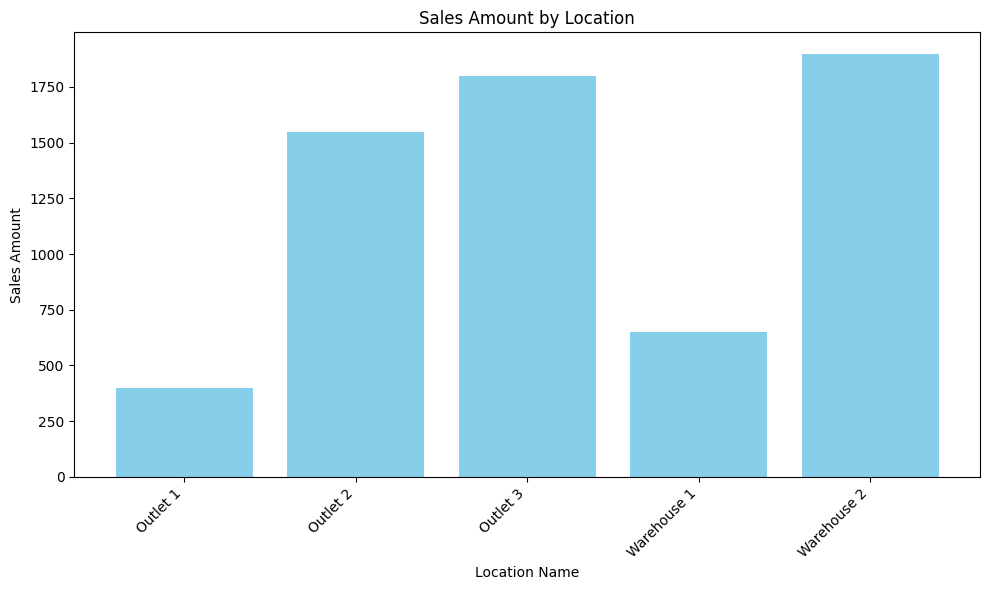

In [50]:
execution.results[0]

# Demo

## Few Shot Prep

In [15]:
user_query_v1 = "I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please output the results in a table where column headers are outlet names and row headers are product names"
print(user_query_v1)

I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please output the results in a table where column headers are outlet names and row headers are product names


In [16]:
expected_response_v1 = """
SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'T0001')
GROUP BY p.product_code;
"""
print(expected_response_v1)


SELECT 
    p.product_code,
    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS "Outlet 1" ,
    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS "Outlet 2"
FROM datachat_outlet o
    JOIN datachat_invoice i ON i.origin_address_id = o.address_id
        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id
            JOIN datachat_product p ON p.id = ii.product_id
WHERE p.product_code IN ('D0001', 'T0001')
GROUP BY p.product_code;



In [22]:
user_query_v2 = "I want to find out what percentage of my total sales come from outlet sales"
print(user_query_v2)

I want to find out what percentage of my total sales come from outlet sales


In [20]:
expected_response_v2 = """
SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS outlet_sales_percentage
FROM datachat_invoice i
JOIN datachat_outlet w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 1;
"""
print(expected_response_v2)


SELECT 
  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS outlet_sales_percentage
FROM datachat_invoice i
JOIN datachat_outlet w 
    ON i.origin_address_id = w.address_id
WHERE i.origin_address_type = 1;



In [21]:
fewshot_examples_lst = [
    user_query_v1, expected_response_v1,
    user_query_v2, expected_response_v2,
]
pprint(fewshot_examples_lst)

['I want to find out how D0001 and T0001 perform across outlets 1 to 2. Please '
 'output the results in a table where column headers are outlet names and row '
 'headers are product names',
 '\n'
 'SELECT \n'
 '    p.product_code,\n'
 '    SUM(CASE WHEN o.name = "Outlet 1" THEN ii.line_total ELSE 0 END) AS '
 '"Outlet 1" ,\n'
 '    SUM(CASE WHEN o.name = "Outlet 2" THEN ii.line_total ELSE 0 END) AS '
 '"Outlet 2"\n'
 'FROM datachat_outlet o\n'
 '    JOIN datachat_invoice i ON i.origin_address_id = o.address_id\n'
 '        JOIN datachat_invoiceitem ii ON ii.invoice_id = i.invoice_id\n'
 '            JOIN datachat_product p ON p.id = ii.product_id\n'
 "WHERE p.product_code IN ('D0001', 'T0001')\n"
 'GROUP BY p.product_code;\n',
 'I want to find out what percentage of my total sales come from outlet sales',
 '\n'
 'SELECT \n'
 '  (SUM(i.total) * 100.0 / (SELECT SUM(total) FROM datachat_invoice)) AS '
 'outlet_sales_percentage\n'
 'FROM datachat_invoice i\n'
 'JOIN datachat_outlet w \n'
